In [1]:
# package imports
import os
import cv2
import time
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

### Adaptive Binarization 

In [3]:
def interpolate_non_base_thresholds(thresh_array, gray_img):
    """
    Interpolate/upscale threshold array based on bilinear interpolation
    Args:
        thresh_array: threshold array to be interpolated
        gray_img: original gray image

    Returns: binarized_image, interpolated_threshold_array
    """
    x = np.linspace(0, 1, thresh_array.shape[0])
    y = np.linspace(0, 1, thresh_array.shape[1])
    f = interpolate.interp2d(y, x, thresh_array, kind='linear')

    x2 = np.linspace(0, 1, gray_img.shape[0])
    y2 = np.linspace(0, 1, gray_img.shape[1])
    interp_thresholds = f(y2, x2)
    print(f"Threshold array transformed to original image size: {interp_thresholds.shape == gray_img.shape}")

    # binarizing grayscale image using pixel level interpolated thresholds 
    bin_image = gray_img - interp_thresholds
    bin_image[bin_image > 0] = np.uint8(255)
    bin_image[bin_image <= 0] = np.uint8(0)
    plt.figure(figsize=(10, 10))
    plt.imshow(bin_image, cmap='Greys_r')
    return bin_image, interp_thresholds


def SouvolaBinarization(image, kernel=3, stride=1, k=0.5, R=128.0):
    """
    Souvola binarization function
    Args:
        image: input grayscale image
        kernel: window size for calculating local descriptive stats
        stride: kernel stride. Higher stride reduces tat but makes more threshold approximation
        k: formula constant
        R: formula constant

    Returns: binarized_image
    """
    gray_img = image.copy()
    
    if kernel<3:
        print("Kernel size should be >=3")
        return

    if image.dtype != "uint8":
        print("Image dtype should be uint8")
        return

    if R <= 0:
        print("Invalid argument R, should be >0")
        return

    # initializing variables
    inverse_area = 1 / (kernel ** 2)
    inverse_R = 1 / R

    # padding image based on kernel size
    pad = kernel // 2
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad, cv2.BORDER_REPLICATE)
    rows, cols = image.shape[0], image.shape[1]
    
    # calculating intergral arrays of sum and square sum of image array
    sumVal, sqSumVal = cv2.integral2(image)

    thresholds = []
    h = 0
    # iterating over image pixels to calculate pixel level threshold
    for i in range(pad, rows - pad, stride):
        h += 1
        w = 0
        for j in range(pad, cols - pad, stride):
            w += 1
            tl = (i - pad - 1, j - pad - 1)
            br = (i + pad, j + pad)
            bl = (i + pad, j - pad - 1)
            tr = (i - pad - 1, j + pad)
            _tl = 0 if min(tl) < 0 else 1
            _br = 0 if min(br) < 0 else 1
            _bl = 0 if min(bl) < 0 else 1
            _tr = 0 if min(tr) < 0 else 1
            
            # using intergral image to calculate ROI mean and standard deviation in O(1) time
            s1 = (_br * sumVal[br]) + (_tl * sumVal[tl]) - (_bl * sumVal[bl]) - (_tr * sumVal[tr])
            s2 = (_br * sqSumVal[br]) + (_tl * sqSumVal[tl]) - (_bl * sqSumVal[bl]) - (_tr * sqSumVal[tr])
            mean = s1 * inverse_area
            var = (s2 - ((s1 ** 2) * inverse_area)) * inverse_area
            if var < 0:
                std = 0
            else:
                std = np.sqrt(var)

            # calculate binarization threshold based on formula
            thresh = (mean) * (1 + k * ((std * inverse_R) - 1))
            thresholds.append(thresh)
    
    # resize threshold array for interpolation of non base pixels
    thresh_array = np.array(thresholds).reshape((h, w))
    bin_img, interp_thresh = interpolate_non_base_thresholds(thresh_array, gray_img)

    return bin_img

### Test examples below

Threshold array transformed to original image size: True
tat: 4120.0 ms


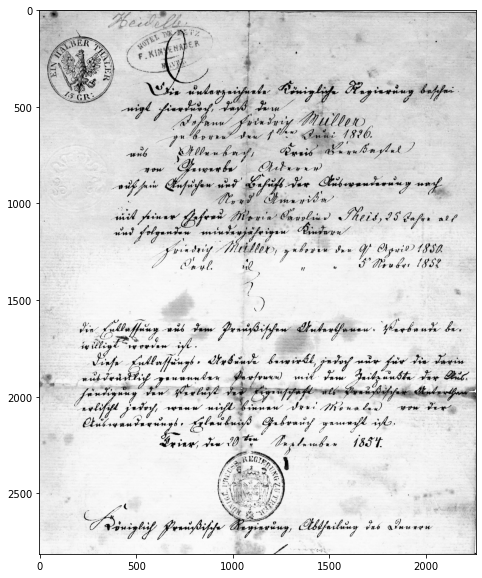

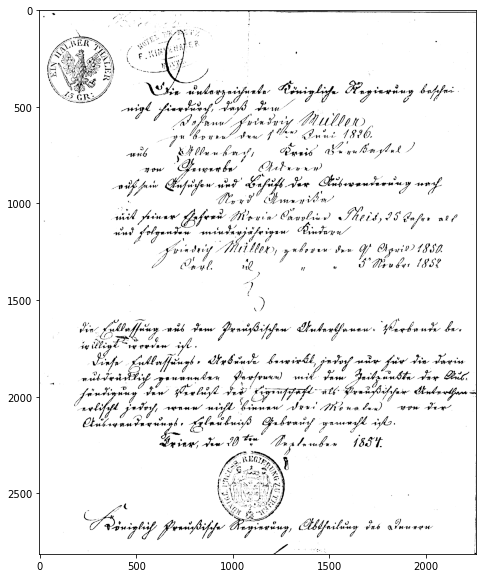

In [105]:
gray = cv2.imread("./binarization_test_images/01.jpeg", 0)
plt.figure(figsize=(10,10))
plt.imshow(gray, cmap='Greys_r')
start = time.time()
binarized = SouvolaBinarization(gray, kernel=11, stride=5, k=0.4, R=128.0)
print(f"tat: {round((time.time()-start), 2)*1000} ms")

Threshold array transformed to original image size: True
tat: 340.0 ms


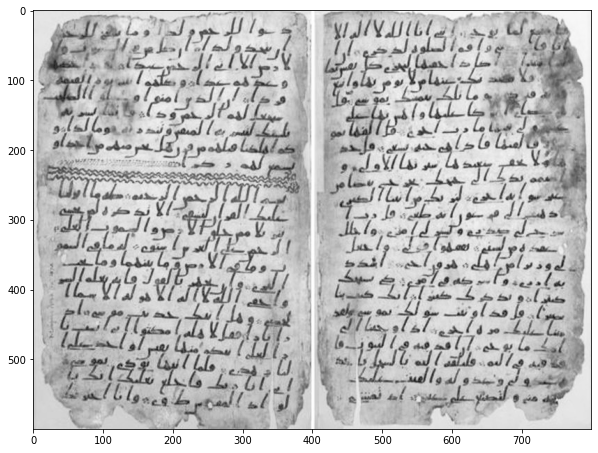

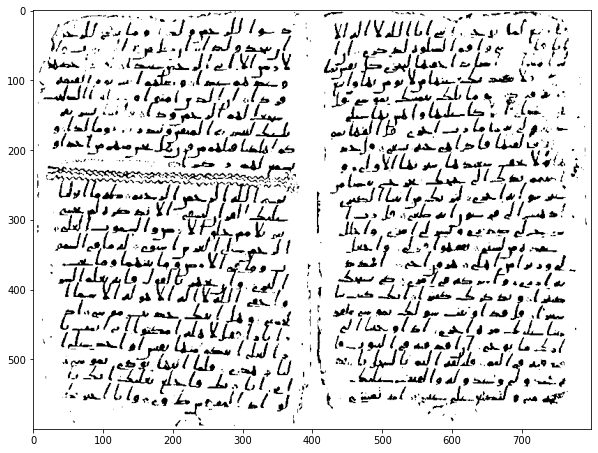

In [19]:
gray = cv2.imread("./binarization_test_images/text.jpeg", 0)
plt.figure(figsize=(10,10))
plt.imshow(gray, cmap='Greys_r')
start = time.time()
binarized = SouvolaBinarization(gray, kernel=13, stride=5, k=0.25, R=128.0)
print(f"tat: {round((time.time()-start), 2)*1000} ms")

Threshold array transformed to original image size: True
tat: 120.0 ms


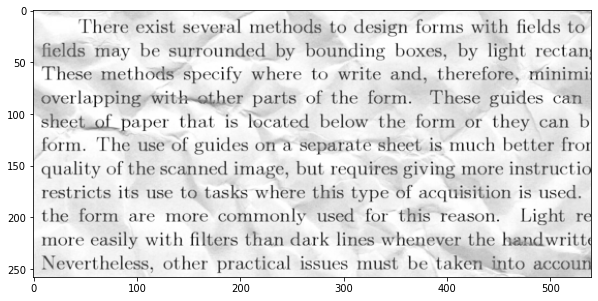

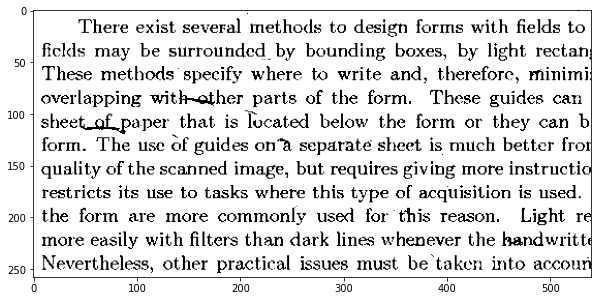

In [119]:
gray = cv2.imread("./binarization_test_images/crushed.png", 0)
plt.figure(figsize=(10,10))
plt.imshow(gray, cmap='Greys_r')
start = time.time()
binarized = SouvolaBinarization(gray, kernel=13, stride=5, k=0.28, R=128.0)
print(f"tat: {round((time.time()-start), 2)*1000} ms")